In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

In [2]:
# Set the path to the data
DATA_PATH = os.path.join('MP_Data')

# Define the actions and label map
actions = np.array(['Hello', 'Namaste', 'My name is', 'Indian', 'Sign', 'Language', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'Hello': 0,
 'Namaste': 1,
 'My name is': 2,
 'Indian': 3,
 'Sign': 4,
 'Language': 5,
 'A': 6,
 'B': 7,
 'C': 8,
 'D': 9,
 'E': 10,
 'F': 11,
 'G': 12,
 'H': 13,
 'I': 14,
 'J': 15,
 'K': 16,
 'L': 17,
 'M': 18,
 'N': 19,
 'O': 20,
 'P': 21,
 'Q': 22,
 'R': 23,
 'S': 24,
 'T': 25,
 'U': 26,
 'V': 27,
 'W': 28,
 'X': 29,
 'Y': 30,
 'Z': 31}

In [3]:
# Define the sequence length and tokenization function
sequence_length = 30

def tokenize_sequence(sequence):
    return sequence  # No need to flatten, as the input is already a 1D array

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [4]:
# Convert sequences to tokenized format
tokenized_sequences = [tokenize_sequence(seq) for seq in sequences]

# Convert labels to one-hot encoded format
y = to_categorical(labels).astype(int)

# Convert the tokenized sequences and labels to NumPy arrays
X = np.array(tokenized_sequences)
y = np.array(y)

# Reshape the input data to be compatible with the Transformer model
# The input shape for the Transformer model should be (sequence_length, feature_dim)
# In this case, the feature_dim is 4, as each frame is represented by a 1D array of length 4
X = X.reshape(X.shape[0], sequence_length, -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Define the input shape for the Transformer model
input_shape = X_train.shape[1:]

In [5]:
# Check the shapes of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Input shape for Transformer model:", input_shape)

X_train shape: (1520, 30, 258)
y_train shape: (1520, 32)
X_test shape: (80, 30, 258)
y_test shape: (80, 32)
Input shape for Transformer model: (30, 258)


# Train with Datat Augmentation

In [6]:
# Data augmentation function
def augment_data(sequences, labels):
    augmented_sequences, augmented_labels = [], []
    for seq, label in zip(sequences, labels):
        augmented_sequences.append(seq)
        augmented_labels.append(label)

        # Apply data augmentation: You can add more augmentations as needed
        flipped_seq = np.flip(seq, axis=1)  # Flip horizontally
        augmented_sequences.append(flipped_seq)
        augmented_labels.append(label)

        # Add more augmentations here like random cropping, rotation, etc.

    return np.array(augmented_sequences), np.array(augmented_labels)

# Augment the data
X_train_aug, y_train_aug = augment_data(X_train, y_train)

In [12]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

n_classes = len(actions)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    regularization_strength=1e-5,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.BatchNormalization()(x)  # Add batch normalization for stabilization
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax", kernel_regularizer=keras.regularizers.l2(regularization_strength))(x)
    return keras.Model(inputs, outputs)

# Define the input shape for the 1D array representation
input_shape = (30, 258)

# Define the model parameters
head_size = 16
num_heads = 4
ff_dim = 64
num_transformer_blocks = 6
mlp_units = [256, 128]

# Build the Transformer model with regularization
model = build_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.1,
    mlp_dropout=0.4,
    regularization_strength=1e-5,
)



In [9]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 258)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 30, 258)     516         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 30, 258)     66498       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 30, 258)     516         ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 30, 64)       16576       ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 30, 64)       0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 30, 258)      16770       ['dropout_7[0][0]']              
          

In [11]:
# Implement learning rate scheduling
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.1
    return lr

# Define callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Train the model
model.fit(
    X_train_aug, y_train_aug,
    batch_size=64,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler_callback],
)

Epoch 1/1000
48/48 [==============================] - 18s 276ms/step - loss: 4.4901 - accuracy: 0.0309 - val_loss: 3.4743 - val_accuracy: 0.0625 - lr: 1.0000e-04
Epoch 2/1000
48/48 [==============================] - 13s 264ms/step - loss: 4.2871 - accuracy: 0.0408 - val_loss: 3.4849 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 3/1000
48/48 [==============================] - 12s 260ms/step - loss: 4.0571 - accuracy: 0.0566 - val_loss: 3.4810 - val_accuracy: 0.0625 - lr: 1.0000e-04
Epoch 4/1000
48/48 [==============================] - 13s 273ms/step - loss: 3.8840 - accuracy: 0.0556 - val_loss: 3.4567 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 5/1000
48/48 [==============================] - 17s 356ms/step - loss: 3.6998 - accuracy: 0.0605 - val_loss: 3.2651 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 6/1000
48/48 [==============================] - 16s 329ms/step - loss: 3.5417 - accuracy: 0.0928 - val_loss: 3.0110 - val_accuracy: 0.1000 - lr: 1.0000e-04
Epoch 7/1000
48/48 [========

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 0s 25ms/step - loss: 2.4876 - accuracy: 0.1625
Test Accuracy: 0.16249999403953552


In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Define the number of classes based on the number of actions
n_classes = len(actions)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

input_shape = (30, 258)  # Update the input shape to match the 1D array representation

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the number of classes based on the number of actions
n_classes = len(actions)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Define the input shape for the 1D array representation
input_shape = (30, 258)

# Define the model parameters
head_size = 8
num_heads = 2
ff_dim = 32
num_transformer_blocks = 2
mlp_units = [16]

# Build the Transformer model
model = build_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.1,
    mlp_dropout=0.1,
)

# Regularisation

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Model, regularizers

def transformer_block(inputs, num_heads, head_size, ff_dim, dropout=0, l2=0):
    # Multi-head attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    # Feed-forward layer with L2 regularization
    ff_output = layers.Dense(ff_dim, activation='relu', kernel_regularizer=regularizers.l2(l2))(attention_output)
    ff_output = layers.Dense(inputs.shape[-1], kernel_regularizer=regularizers.l2(l2))(ff_output)
    ff_output = layers.Dropout(dropout)(ff_output)
    # Residual connection
    ff_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ff_output)
    return ff_output

def build_transformer_model(input_shape, num_heads, head_size, ff_dim, num_transformer_blocks, mlp_units, dropout=0, l2=0):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads, head_size, ff_dim, dropout, l2)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(actions.shape[0], activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = build_transformer_model(
    input_shape=(30, 258),
    num_heads=8,
    head_size=64,
    ff_dim=256,
    num_transformer_blocks=3,
    mlp_units=[64, 32],
    dropout=0.1,
    l2=0.01  # You can adjust the value of l2 regularization here
)


In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 258)]    0           []                               
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 30, 258)     530178      ['input_2[0][0]',                
 eadAttention)                                                    'input_2[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 30, 258)      0           ['multi_head_attention_3[0][0]'] 
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 30, 258)     0           ['input_2[0][0]',          

                                                                                                  
 dropout_15 (Dropout)           (None, 32)           0           ['dense_16[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 32)           1056        ['dropout_15[0][0]']             
                                                                                                  
Total params: 2,011,172
Trainable params: 2,011,172
Non-trainable params: 0
__________________________________________________________________________________________________


In [13]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2000,
    batch_size=32,
    callbacks=[tb_callback]
)

Epoch 1/2000
48/48 [==============================] - 10s 150ms/step - loss: 19.6196 - accuracy: 0.0533 - val_loss: 18.7915 - val_accuracy: 0.1125
Epoch 2/2000
48/48 [==============================] - 7s 139ms/step - loss: 18.0927 - accuracy: 0.1283 - val_loss: 17.2767 - val_accuracy: 0.2250
Epoch 3/2000
48/48 [==============================] - 7s 143ms/step - loss: 16.6713 - accuracy: 0.2171 - val_loss: 15.7959 - val_accuracy: 0.3500
Epoch 4/2000
48/48 [==============================] - 7s 144ms/step - loss: 15.4300 - accuracy: 0.2829 - val_loss: 14.4758 - val_accuracy: 0.4125
Epoch 5/2000
48/48 [==============================] - 7s 154ms/step - loss: 14.2742 - accuracy: 0.3447 - val_loss: 13.3523 - val_accuracy: 0.5250
Epoch 6/2000
48/48 [==============================] - 7s 156ms/step - loss: 13.1960 - accuracy: 0.4388 - val_loss: 12.4977 - val_accuracy: 0.5500
Epoch 7/2000
48/48 [==============================] - 7s 154ms/step - loss: 12.2914 - accuracy: 0.4993 - val_loss: 11.5474 

48/48 [==============================] - 8s 157ms/step - loss: 1.7506 - accuracy: 0.9658 - val_loss: 1.9176 - val_accuracy: 0.9500
Epoch 58/2000
48/48 [==============================] - 8s 157ms/step - loss: 1.6948 - accuracy: 0.9717 - val_loss: 1.8593 - val_accuracy: 0.9500
Epoch 59/2000
48/48 [==============================] - 7s 156ms/step - loss: 1.6582 - accuracy: 0.9750 - val_loss: 1.8176 - val_accuracy: 0.9500
Epoch 60/2000
48/48 [==============================] - 8s 157ms/step - loss: 1.6229 - accuracy: 0.9704 - val_loss: 1.7881 - val_accuracy: 0.9500
Epoch 61/2000
48/48 [==============================] - 8s 157ms/step - loss: 1.5669 - accuracy: 0.9743 - val_loss: 1.7306 - val_accuracy: 0.9500
Epoch 62/2000
48/48 [==============================] - 7s 156ms/step - loss: 1.5337 - accuracy: 0.9737 - val_loss: 1.7869 - val_accuracy: 0.9375
Epoch 63/2000
48/48 [==============================] - 7s 156ms/step - loss: 1.5274 - accuracy: 0.9625 - val_loss: 1.6531 - val_accuracy: 0.9500

KeyboardInterrupt: 

In [14]:
res = model.predict(X_test)

3/3 [==============================] - 1s 71ms/step


In [15]:
actions[np.argmax(res[4])]

'R'

In [16]:
actions[np.argmax(y_test[4])]

'R'

In [17]:
model.save('ntb_action.h5')

In [19]:
!pip install seaborn

  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)


3/3 [==============================] - 0s 52ms/step


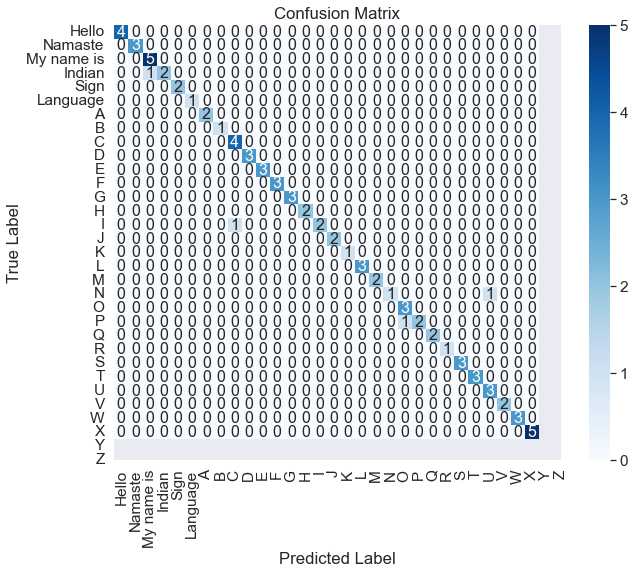

Epoch 1/10
48/48 [==============================] - 10s 205ms/step - loss: 0.4103 - accuracy: 0.9901 - val_loss: 0.6364 - val_accuracy: 0.9375
Epoch 2/10
48/48 [==============================] - 10s 200ms/step - loss: 0.4041 - accuracy: 0.9914 - val_loss: 0.6284 - val_accuracy: 0.9375
Epoch 3/10
48/48 [==============================] - 10s 206ms/step - loss: 0.3906 - accuracy: 0.9947 - val_loss: 0.6190 - val_accuracy: 0.9500
Epoch 4/10
48/48 [==============================] - 10s 212ms/step - loss: 0.4031 - accuracy: 0.9908 - val_loss: 0.6283 - val_accuracy: 0.9500
Epoch 5/10
48/48 [==============================] - 10s 210ms/step - loss: 0.4016 - accuracy: 0.9921 - val_loss: 0.6378 - val_accuracy: 0.9500
Epoch 6/10
48/48 [==============================] - 10s 210ms/step - loss: 0.3822 - accuracy: 0.9928 - val_loss: 0.6393 - val_accuracy: 0.9500
Epoch 7/10
48/48 [==============================] - 10s 212ms/step - loss: 0.3766 - accuracy: 0.9928 - val_loss: 0.6148 - val_accuracy: 0.9500

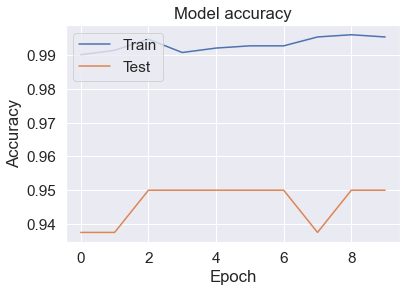

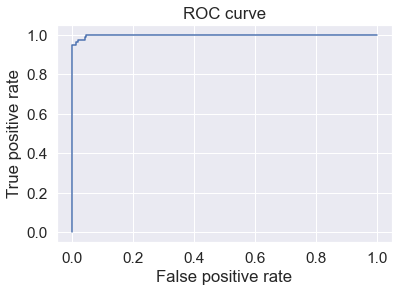

3/3 [==============================] - 0s 14ms/step


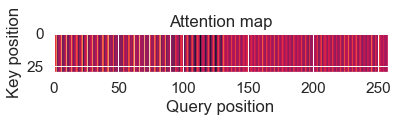

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
class_labels = ['Hello', 'Namaste', 'My name is', 'Indian', 'Sign', 'Language', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
plt.figure(figsize=(10, 8))


sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Learning curves
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ROC curves
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# Attention maps
# This assumes that the model has a layer named 'multi_head_attention' that outputs attention weights
attention_model = Model(inputs=model.input,
                        outputs=model.get_layer('multi_head_attention_3').output)
attention_weights = attention_model.predict(X_test)
# Plot the attention weights for the first example in the test set
plt.imshow(attention_weights[0])
plt.title('Attention map')
plt.xlabel('Query position')
plt.ylabel('Key position')
plt.show()
